## Connect and List Entries

Connect to your ReductStore instance and list the entries in a bucket.

In [1]:
import pandas as pd
from reduct import Client

REDUCT_URL = "http://orion.field.demo/"
API_TOKEN = "demo"
BUCKET = "orion"
MCAP_BUCKET = "mcap"

async with Client(REDUCT_URL, api_token=API_TOKEN) as client:
    bucket = await client.get_bucket(BUCKET)
    entries = await bucket.get_entry_list()
    df = (
        pd.DataFrame([{"entry": e.name} for e in entries])
        .sort_values("entry")
        .reset_index(drop=True)
    )

df.head()

,entry
0,camera_info
1,image
2,imu
3,magnetic_field
4,point_cloud


## Extract Tabular Data from JSON

Select IMU columns and filter rows with positive acceleration in Z axis.

In [2]:
import json
import pandas as pd
from reduct import Client

JSON_ENTRY = "imu"


when = {
    "#ext": {
        # Select only needed columns
        "select": {
            "json": {},
            "columns": [
                {"name": "ts_ns"},
                {"name": "linear_acceleration.z", "as_label": "acc_z"},
            ],
        },
        "when": {
            "$and": [
                # filter rows/entities per record
                {"@acc_z": {"$gt": 5.0}},
                # limit rows/entities per record
                {"$limit": 1000},
            ]
        },
    },
    # Limit the number of proessed records
    "$limit": 10,
}


async with Client(REDUCT_URL, api_token=API_TOKEN) as client:
    bucket = await client.get_bucket(BUCKET)
    parts = []
    async for rec in bucket.query(JSON_ENTRY, when=when):
        blob = await rec.read_all()
        rows = json.loads(blob.decode("utf-8"))
        dict_rows = [
            {
                "ts_ns": row["ts_ns"],
                "acc_z": row["linear_acceleration"]["z"],
            }
            for row in rows
        ]

        parts.append(pd.DataFrame(i for i in dict_rows))
    df_json = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

df_json.head(5)

,ts_ns,acc_z
0,1760687627123628898,6.220092
1,1760687627153628221,5.875758
2,1760687627178595474,6.246162
3,1760687627233616341,5.065308
4,1760687627752852131,6.766597


## Extract from MCAP

Extract `/vectornav/IMU_restamped` messages directly from `mcap` files and load them into a DataFrame.

In [6]:
import json
import pandas as pd
from reduct import Client

MCAP_ENTRY = "episodes"
IMU_TOPIC = "/vectornav/IMU_restamped"

# MCAP files are split into 30-second episodes (5 minutes = 10 episodes)
start = "2025-11-11T12:47:00Z"
stop = "2025-11-11T12:47:30Z" 

ext = {
    # MCAP files with ROS 2 messages
    "ros": {
        # Extract only IMU topic messages
        "extract": {"topic": IMU_TOPIC},
    },
}

async with Client(REDUCT_URL, api_token=API_TOKEN) as client:
    bucket = await client.get_bucket(MCAP_BUCKET)
    rows = []
    async for rec in bucket.query(MCAP_ENTRY, start, stop, ext=ext):
        # Decode and split concatenated JSON objects
        text = (await rec.read_all()).decode("utf-8", errors="ignore")
        for line in text.replace("}{", "}\n{").splitlines():
            line = line.strip()
            if not line:
                continue
            try:
                data = json.loads(line)
            except json.JSONDecodeError:
                continue
            stamp = data.get("header", {}).get("stamp", {})
            ts_ns = stamp.get("sec", 0) * 1_000_000_000 + stamp.get("nanosec", 0)
            la = data.get("linear_acceleration", {})
            rows.append(
                {
                    "ts_ns": ts_ns,
                    "linear_acceleration_x": la.get("x"),
                    "linear_acceleration_y": la.get("y"),
                    "linear_acceleration_z": la.get("z"),
                }
            )

    df_ros = pd.DataFrame(rows).set_index("ts_ns") if rows else pd.DataFrame()

print(f"Processed {len(df_ros)} IMU messages from ROS MCAP files.")
df_ros.head()

Processed 5002 IMU messages from ROS MCAP files.


,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z
ts_ns,,,
1709997000229975917,-6.250413,-2.114476,1.489746
1709997000234446349,-8.427048,-2.131894,-1.303165
1709997000239057931,-10.157822,-2.105166,-1.244579
1709997000243486588,-9.210403,-1.092848,0.170117
1709997000250157069,-8.917986,0.997710,1.738704


## Vizualize in Foxglove

Create a sharable link to visualize the extracted data in Foxglove.

In [7]:
from datetime import datetime, timedelta

# MCAP files are split into 30-second episodes (5 minutes = 10 episodes)
start = "2025-11-11T12:47:00Z"
stop = "2025-11-11T12:47:30Z" 

# Link 30 days expiration
expire_at = datetime.now() + timedelta(days=30)
record_index = 0
file_name = f"episode_{record_index:04d}.mcap"

async with Client(REDUCT_URL, api_token=API_TOKEN) as client:
    bucket = await client.get_bucket(MCAP_BUCKET)
    link = await bucket.create_query_link(MCAP_ENTRY, start, stop, expire_at=expire_at, record_index=record_index, file_name=file_name)
    print(link)


http://orion.field.demo/api/v1/links/episode_0000.mcap?ct=5PgW_mXICWY7oIST5qWmdPFdACMjIjgA-RuAvMD3u1cDgLE20MYtkUHDtSO3sj9x1HCL4zaOgz4KEICHJ3qHswiEtMHkRepEVPuUhl49tKO_8oWUWYsLq3INbHyxp8MD9J24DbUkASeesbNPqGKaEjWPAJIbK6OmdGBQ8uzZH80prd8hTrdip6Pk0_A8XlxFsqmGTqFUDKCvGX1dS4LcGc8BG3ZlR0EvUpLm22ehXOScl51sf9fRQBr0PDC5guMDmqEBOP-4NKYW&s=JshkMFpiywt4hsuqTlklsw&i=AUTHENTICATION-DISABLED&n=Yc3jvqn2xpuxecXwajha2w&r=0


## Extract raw images

Read a few images and display them.

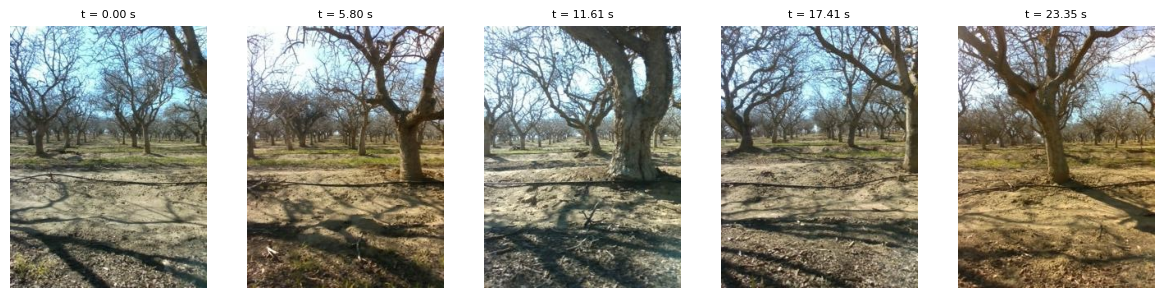

In [8]:
import io
from PIL import Image
import matplotlib.pyplot as plt
from reduct import Client

ENTRY = "image"
MAX_FRAMES = 5

imgs, timestamps, labels = [], [], []

# Sample every 5 seconds, up to MAX_FRAMES frames
when = {"$each_t": "5s", "$limit": MAX_FRAMES}

async with Client(REDUCT_URL, api_token=API_TOKEN) as client:
    bucket = await client.get_bucket(BUCKET)
    async for rec in bucket.query(ENTRY, when=when):
        blob = await rec.read_all()
        imgs.append(Image.open(io.BytesIO(blob)))
        timestamps.append(rec.timestamp)
        labels.append(rec.labels)

t0 = timestamps[0] if timestamps else 0
rel_times = [(ts - t0) / 1e6 for ts in timestamps]

fig, axes = plt.subplots(1, len(imgs), figsize=(12, 3))

for ax, im, t, lbl in zip(axes, imgs, rel_times, labels):
    ax.imshow(im)
    ax.axis("off")
    ax.set_title(f"t = {t:.2f} s", fontsize=8)

plt.tight_layout()
plt.show()

## Extract raw PointCloud2

Read a few PointCloud2 frames and visualize them.

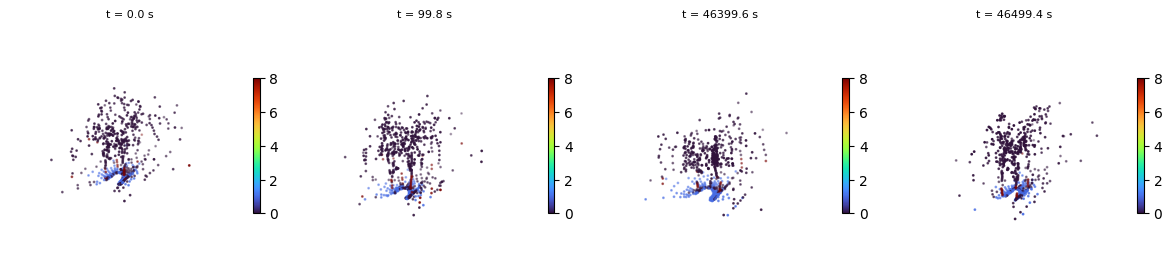

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from reduct import Client

ENTRY = "point_cloud"
MAX_SCANS = 4
when = {"$each_t": "5s", "$limit": MAX_SCANS}

scans, metas, stamps = [], [], []
async with Client(REDUCT_URL, api_token=API_TOKEN) as client:
    bucket = await client.get_bucket(BUCKET)
    async for rec in bucket.query(ENTRY, when=when):
        scans.append(await rec.read_all())
        metas.append(rec.labels)
        stamps.append(rec.timestamp)


def to_xyz(blob, meta):
    ps = int(meta["point_step"])
    dt = np.dtype(
        {
            "names": ["x", "y", "z", "intensity"],
            "formats": ["<f4", "<f4", "<f4", "<f4"],
            "offsets": [0, 4, 8, 12],
            "itemsize": ps,
        }
    )
    pc = np.frombuffer(blob, dtype=dt)
    return pc["x"], pc["y"], pc["z"], pc["intensity"]


t0 = stamps[0] if stamps else 0
rel_t = [(t - t0) / 1e6 for t in stamps]

fig = plt.figure(figsize=(12, 3))
for i, (blob, meta, t) in enumerate(zip(scans, metas, rel_t), 1):
    x, y, z, inten = to_xyz(blob, meta)
    s = 100  # take every 100th point
    ax = fig.add_subplot(1, len(scans), i, projection="3d")
    p = ax.scatter(x[::s], y[::s], z[::s], c=inten[::s], cmap="turbo", s=1)
    ax.set_title(f"t = {t:.1f} s", fontsize=8)
    ax.axis("off")
    fig.colorbar(p, ax=ax, shrink=0.5, pad=0.01)

plt.tight_layout()
plt.show()